# Thesis Title: Reinforcement Learning Models for Parsing Jazz Harmonies Using Probabilistic Abstract Context-Free Grammars 


## Exploratory Data Analysis

Martin Aviles 12825387



## Dataset: Jazz Harmony Treebank

D. Harasim, C. Finkensiep, P. Ericson, T. J. O'Donnell, and M. Rohrmeier (2020). The Jazz Harmony Treebank. In Proceedings of the 21th International Society for Music Information Retrieval Conference, pp. 207-215. Montréal, Canada. https://doi.org/10.5281/zenodo.4245406



### Fields Description

- **`title`**:  
  The name of the tune.

- **`chords`**:  
  A list of chord symbols aligned with `measures` and `beats`.  
  - Format:  
    - **Root**: A-G with optional sharp `#` or flat `b`  
    - **Type**:  
      - `m` = minor  
      - `+` = augmented  
      - `%` = half-diminished  
      - `o` = fully diminished  
      - `sus` = suspended  
      - *(no symbol)* = major  
    - **Extensions**: Optional `6`, `7`, or `^7` (major 7th)

- **`measures`**:  
  A monotonically increasing list of integers indicating the measure number.  
  - Repeated numbers = multiple chords in the same measure.

- **`beats`**:  
  List of beat positions for chord onsets.  
  - Always includes 1 (downbeat).  
  - Additional integers indicate other beat positions within the same measure.

- **`turnaround`**:  
  Integer specifying the final tonic chord position:
  - `0` = last chord is tonic  
  - `2` = third last chord is tonic  
  - `-1` = repeat tune and end on the first chord

- **`trees`** *(if present)*:  
  Tree-based harmonic analyses:
  - **`open_constituent_tree`**: Phrase and harmonic structure  
  - **`complete_constituent_tree`**: Pure harmonic reference  
  - Format: Recursive JSON with:
    - `label`: chord
    - `children`: 0 or 2 subtrees

- **`comments`**:  
  Notes from the annotation process, including:
  - Alternate chord versions  
  - Fixes, ambiguities, etc.

- **`composers`**:  
  Composer name(s) from the iRealPro corpus.

- **`year`**:  
  Year of composition (integer).

- **`meter`**:  
  Time signature:
  ```json
  {
    "numerator": <int>,
    "denominator": <int>
  }


The primary objective of this notebook is to identify patterns in the expert-annotated trees in order to understand the implications of applying various grammar rules.

In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from pychord import Chord
from copy import deepcopy
from pychord.utils import note_to_val
from scipy import stats
import re

In [2]:
data = pd.read_json('./eda/JazzHarmonyTreebank/treebank.json')

In [29]:
take_five = data[data['title'] == 'Take Five']
pd.set_option('display.max_columns', None)
print(take_five.to_string())

Empty DataFrame
Columns: [title, measures, beats, chords, composers, year, meter, key, turnaround, trees, comments]
Index: []


### Helper Functions

Since we are working with tree data, it is important to set up helper functions to make it easier to traverse each tree.

In [3]:
def add_chords_to_dict(dictionary, chords):
    for chord in chords:
        if chord not in dictionary:
            dictionary[chord] = 1
        else:
            dictionary[chord] += 1


In [4]:
class Node:
    def __init__(self, label, children=None):
        self.label = label
        self.children = children if children is not None else []

    def __repr__(self):
        return f"Node({self.label!r}, {self.children!r})"




In [9]:
data['label']

KeyError: 'label'

In [5]:
def build_tree(data):

    return Node(data['label'], [build_tree(child) for child in data.get('children', [])])

In [8]:
def count_rule_applications(node, counter):
    if node.children:
        rule = (node.label, tuple(child.label for child in node.children))
        counter[rule] += 1
        for child in node.children:
            count_rule_applications(child, counter)


In [6]:
def traverse(node, depth=0):
    for child in node.children:
        traverse(child, depth + 1)

In [7]:
def get_depth(node):
    if not node["children"]:
        return 1
    return 1 + max(get_depth(child) for child in node["children"])

### Initial Dataset Exploration

In [11]:
print("Pieces without tree annotations:",len(data[data['trees'].isna()]))
print("Pieces with tree annotations:",len(data[data['trees'].notna()]))

Pieces without tree annotations: 1020
Pieces with tree annotations: 150


### Most Commonly Occuring Tonal Centers

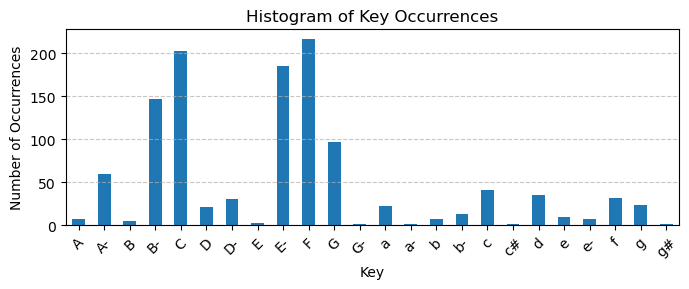

In [12]:
key_counts = data['key'].value_counts().sort_index()

plt.figure(figsize=(7, 3))
key_counts.plot(kind='bar')
plt.title('Histogram of Key Occurrences')
plt.xlabel('Key')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Most Commonly Used Chords 

In [ ]:
chords = {}
data[data['chords'].notna()].apply(lambda x: add_chords_to_dict(chords, x['chords']), axis=1)

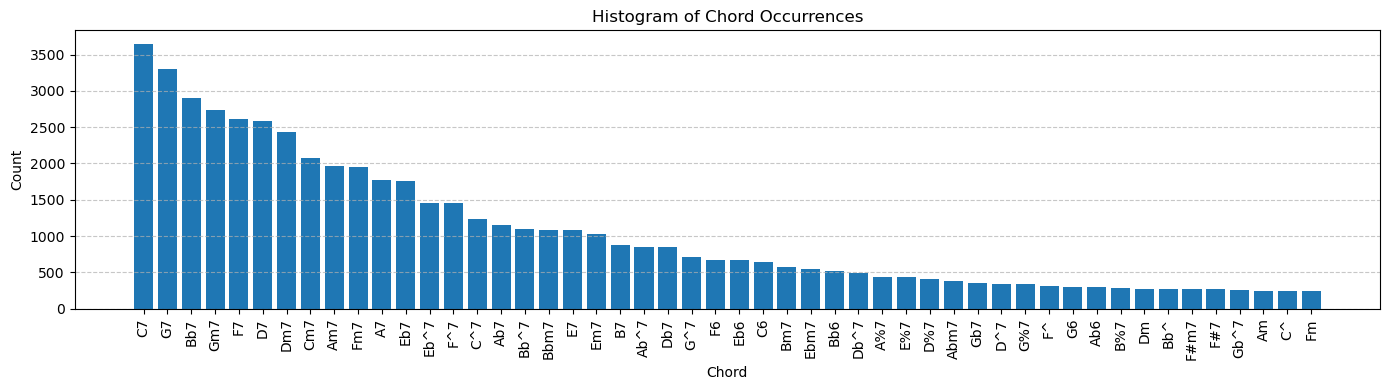

In [14]:
chords_df = pd.DataFrame(list(chords.items()), columns=['Chord', 'Count'])

chords_df_sorted = chords_df.sort_values(by="Count", ascending=False).head(50)

plt.figure(figsize=(14, 4))
plt.bar(chords_df_sorted['Chord'], chords_df_sorted['Count'])
plt.title('Histogram of Chord Occurrences')
plt.xlabel('Chord')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Fun Tree Stuff: Finding Patterns in Expert Annotations

In [15]:
data_with_trees = data[data['trees'].notna()]

In [ ]:
trees = []
data_with_trees['trees'].apply(lambda x: trees.append(x[0]['complete_constituent_tree']))

#### Most Common Rule Applications

In [17]:
rule_counter = defaultdict(int)

for tree in trees:
    root = build_tree(tree)
    traverse(root)
    count_rule_applications(root, rule_counter)
    for rule, count in rule_counter.items():
        parent, children = rule

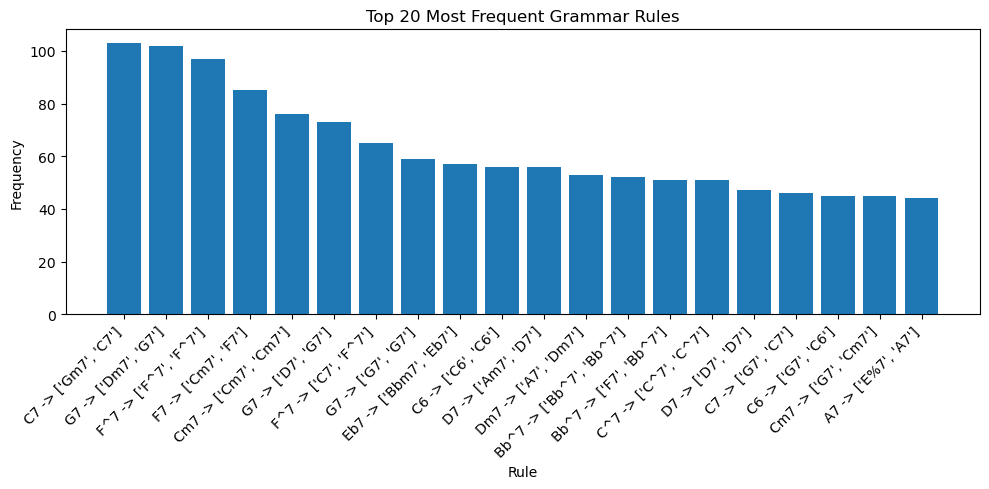

In [18]:
rules_df = pd.DataFrame([(f"{parent} -> {list(children)}", count) 
                        for (parent, children), count in rule_counter.items()],
                       columns=['Rule', 'Frequency'])

rules_df = rules_df.sort_values('Frequency', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(range(20), rules_df['Frequency'].head(20))
plt.xticks(range(20), rules_df['Rule'].head(20), rotation=45, ha='right')
plt.title('Top 20 Most Frequent Grammar Rules')
plt.xlabel('Rule')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [19]:
sequence_lengths = list(data_with_trees['chords'].apply(lambda x: len(x)))
tree_depths = [get_depth(tree) for tree in trees]

lengths_depths = pd.DataFrame({'sequence_lengths':sequence_lengths, 'tree_depths': tree_depths})


### Plotting Sequence Against Tree Depth
#### Identifying if the length of a chord sequence implies a deeper tree depth

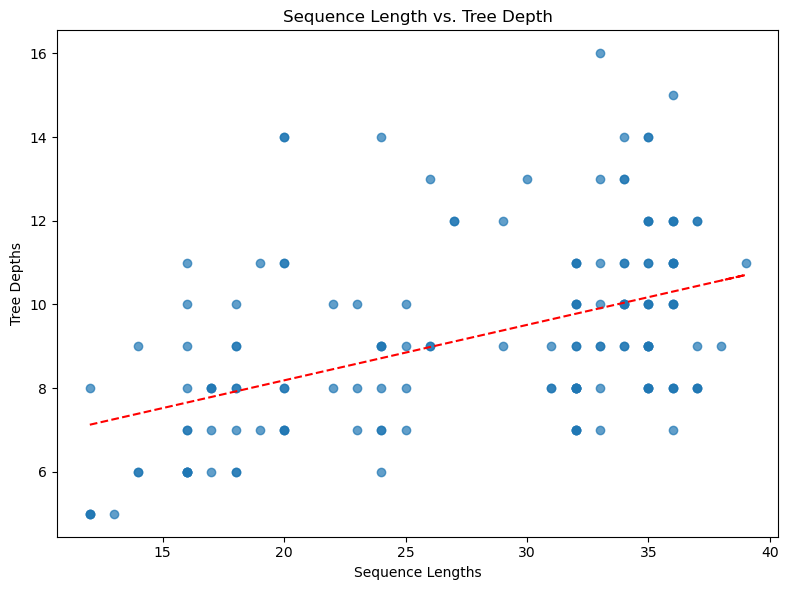

In [20]:

plt.figure(figsize=(8, 6))

plt.scatter(lengths_depths["sequence_lengths"], lengths_depths["tree_depths"], alpha=0.7)

slope, intercept, r_value, p_value, std_err = stats.linregress(lengths_depths["sequence_lengths"], lengths_depths["tree_depths"])
line = slope * lengths_depths["sequence_lengths"] + intercept
plt.plot(lengths_depths["sequence_lengths"], line, color='red', linestyle='--')

plt.title("Sequence Length vs. Tree Depth")
plt.xlabel("Sequence Lengths")
plt.ylabel("Tree Depths")
plt.tight_layout()
plt.show()